# Comics Rx
## [A comic book recommendation system](https://github.com/MangrobanGit/comics_rx)
<img src="https://images.unsplash.com/photo-1514329926535-7f6dbfbfb114?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=2850&q=80" width="400" align='left'>

---

# Reduced Data: Grid Search + Cross-Validation

This time, as explored in the EDA NB, let's consider removing customers who we feel have too few or too many purchases to influence the model in the intended way.

Examples:
- Too few - Customers who have only bought 1 comic (series).
- Too many - Customers with > 1000 series (for example, think all eBay customers are rolled into one account number).

# Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
# %autoreload 1 #would be where you need to specify the files
# %aimport comic_recs

import pandas as pd # dataframes
import os
import pickle

# Data storage
from sqlalchemy import create_engine # SQL helper
#import psycopg2 as psql #PostgreSQL DBs

# import necessary libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.sql.types import (StructType, StructField, IntegerType
#                                ,FloatType, LongType, StringType)
from pyspark.sql.types import *

import pyspark.sql.functions as F
from pyspark.sql.functions import col, explode, lit, isnan, when, count
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import (CrossValidator, ParamGridBuilder, 
                               TrainValidationSplit)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import DataFrame

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys

In [3]:
sys.path.append('..')

In [4]:
# Custom
import data_fcns as dfc
import keys  # Custom keys lib
import comic_recs as cr

import time
import itertools
from functools import reduce
import numpy as np

In [5]:
from pyspark import SparkConf

conf = SparkConf()

conf = (conf.setMaster('local[*]')
#         .set('spark.executor.memory', '1G') #https://stackoverflow.com/questions/48523629/spark-pyspark-an-error-occurred-while-trying-to-connect-to-the-java-server-127
        .set('spark.driver.memory', '7G')
        .set('spark.driver.maxResultSize', '2G'))
#         .set('spark.executor.memory', '1G')
#         .set('spark.driver.memory', '10G')
#         .set('spark.driver.maxResultSize', '5G'))

sc = pyspark.SparkContext().getOrCreate(conf=conf)

from pyspark.sql import SQLContext
sql_context = SQLContext(sc)

sc.setCheckpointDir('./checkpoints')

# spark.sparkContext.setCheckpointDir("hdfs://datalake/check_point_directory/als")

In [6]:
# # spark config
# spark = pyspark.sql.SparkSession \
#     .builder \
#     .appName("comic recs") \
#     .config("spark.driver.maxResultSize", "8g") \
#     .config("spark.driver.memory", "8g") \
#     .config("spark.executor.memory", "8g") \
#     .config("spark.master", "local[*]") \
#     .getOrCreate()

# instantiate SparkSession object
spark = pyspark.sql.SparkSession.builder.master("local[*]").getOrCreate()
# spark = SparkSession.builder.master("local").getOrCreate()

# spark config
spark = pyspark.sql.SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "1g") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.memory", "20g") \
    .config("spark.master", "local[*]") \
    .getOrCreate()

## Import Data

We've previously set aside the dataset into a `json` file.

In [7]:
#!ls

In [8]:
# We have previously created a version of the transactions table 
# and filtered it down.
sold = sql_context.read.json('raw_data/als_input_filtered.json')

In [9]:
# Persist the data
sold.persist()

DataFrame[account_id: bigint, bought: bigint, comic_id: bigint]

In [10]:
sold.count()

61871

### ALS Model

Let's start with  train/test split.

In [11]:
random_seed = 1234

In [12]:
# Split data into training and test set
(train, test) = sold.randomSplit([.75, .25], seed=random_seed)

Make sure shapes make sense.

In [13]:
print(train.count(), len(train.columns))

46417 3


In [14]:
print(test.count(), len(test.columns))

15454 3


In [15]:
# Evaluate the model by computing the RMSE on the test data
eval_reg = RegressionEvaluator(metricName="rmse"
                               , labelCol="bought"
                               , predictionCol="prediction")

### Grid Search

Let's further subset into test and validation sets.

In [16]:
# Split data into training and validation sets
(gs_train, gs_val) = train.randomSplit([(1-(1/3)), (1/3)], seed=random_seed)

In [17]:
print(gs_train.count(), len(gs_train.columns))

30854 3


In [18]:
print(gs_val.count(), len(gs_val.columns))

15563 3


In [19]:
# hyper-param config
num_iterations = [5, 10, 20]
ranks = [5, 10, 20]
reg_params = [0.01, 0.1, 1]
alphas = [5, 25, 40]

In [20]:
# grid search and select best model
start_time = time.time()
final_model, params_errs = cr.train_ALS(gs_train, gs_val, eval_reg, 
                                        num_iterations, reg_params, 
                                        ranks, alphas)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

5 iterations, 5 latent factors, regularization=0.01, and alpha @ 5 : validation error is 0.7929
5 iterations, 5 latent factors, regularization=0.01, and alpha @ 25 : validation error is 0.6206
5 iterations, 5 latent factors, regularization=0.01, and alpha @ 40 : validation error is 0.5692
5 iterations, 10 latent factors, regularization=0.01, and alpha @ 5 : validation error is 0.7784
5 iterations, 10 latent factors, regularization=0.01, and alpha @ 25 : validation error is 0.6227
5 iterations, 10 latent factors, regularization=0.01, and alpha @ 40 : validation error is 0.5823
5 iterations, 20 latent factors, regularization=0.01, and alpha @ 5 : validation error is 0.7807
5 iterations, 20 latent factors, regularization=0.01, and alpha @ 25 : validation error is 0.6634
5 iterations, 20 latent factors, regularization=0.01, and alpha @ 40 : validation error is 0.6403
5 iterations, 5 latent factors, regularization=0.1, and alpha @ 5 : validation error is 0.7972
5 iterations, 5 latent factor

Save the descriptive results

In [21]:
param_errs_rd_1 = params_errs

In [22]:
with open('support_data/params_errs_20190912a.pkl', 'wb') as f:
    pickle.dump(param_errs_rd_1, f)
    
# Example - load pickle
# pickle_in = open("support_data/params_errs_rd1.pkl","rb")
# pe1 = pickle.load(pickle_in)

#### Use this to reload the Grid Search results

In [23]:
pickle_in = open('support_data/params_errs_20190912a.pkl', 'rb')
params_errs_1 = pickle.load(pickle_in)
                         

Hmmm. Let's put `params_errs_1` into a dataframe and find the model with the lowest error!

In [24]:
gs_cols = ['max_iters', 'reg', 'rank', 'alpha', 'rmse']

In [25]:
gs_df = pd.DataFrame(params_errs_1, columns=gs_cols)

In [26]:
gs_df.head()

,max_iters,reg,rank,alpha,rmse
0,5,0.01,5,5,0.792942
1,5,0.01,5,25,0.620634
2,5,0.01,5,40,0.569212
3,5,0.01,10,5,0.778440
4,5,0.01,10,25,0.622656


In [27]:
min_err = gs_df.rmse.min()

In [28]:
min_df = gs_df.loc[gs_df['rmse']==min_err]

In [29]:
min_df

,max_iters,reg,rank,alpha,rmse
56,20,0.01,5,40,0.54872


In [30]:
best_max_iter = min_df['max_iters'].iloc[0]
best_reg = min_df['reg'].iloc[0]
best_rank = min_df['rank'].iloc[0]
best_alpha = min_df['alpha'].iloc[0]

Let's do some visual comparisons.

In [31]:
gs_rank_match = (gs_df['rank']==best_rank)
gs_reg_match = (gs_df['reg']==best_reg)
gs_iter_match = (gs_df['max_iters']==best_max_iter)
gs_alpha_match = (gs_df['alpha']==best_alpha)

In [32]:
gs_vary_rank = gs_df.loc[(gs_reg_match & gs_iter_match & gs_alpha_match),:]

In [33]:
gs_vary_rank

,max_iters,reg,rank,alpha,rmse
56,20,0.01,5,40,0.548720
59,20,0.01,10,40,0.561128
62,20,0.01,20,40,0.613422


In [34]:
gs_vary_alpha = gs_df.loc[(gs_reg_match & gs_iter_match & gs_rank_match),:]

In [35]:
gs_vary_alpha

,max_iters,reg,rank,alpha,rmse
54,20,0.01,5,5,0.784188
55,20,0.01,5,25,0.605789
56,20,0.01,5,40,0.548720


In [36]:
gs_vary_reg = gs_df.loc[(gs_alpha_match & gs_iter_match & gs_rank_match),:]

In [37]:
gs_vary_reg

,max_iters,reg,rank,alpha,rmse
56,20,0.01,5,40,0.548720
65,20,0.10,5,40,0.550177
74,20,1.00,5,40,0.554570


In [38]:
gs_vary_iter = gs_df.loc[(gs_alpha_match & gs_reg_match & gs_rank_match),:]

In [39]:
gs_vary_iter

,max_iters,reg,rank,alpha,rmse
2,5,0.01,5,40,0.569212
29,10,0.01,5,40,0.553523
56,20,0.01,5,40,0.548720


So quick inspection on these, lets:
- Keep `rank` = 5  
- Stick with regularization parameter at `0.01`.  
- Max iterations it seems will plateau, but let's investigate going up to maybe 30 or so.
- Looking like going higher on alpha might lower RMSE more.


So let's go through another grid of parameters.

In [40]:
# hyper-param config
num_iterations = [20, 30, 40]
ranks = [5]
reg_params = [0.01]
alphas = [40, 50, 100]

In [47]:
# grid search and select best model
start_time = time.time()
final_model, params_errs_2 = cr.train_ALS(gs_train, gs_val, eval_reg, 
                                        num_iterations, reg_params, 
                                        ranks, alphas)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

20 iterations, 5 latent factors, regularization=0.01, and alpha @ 50 : validation error is 0.5237
20 iterations, 5 latent factors, regularization=0.01, and alpha @ 100 : validation error is 0.4548
20 iterations, 5 latent factors, regularization=0.01, and alpha @ 500 : validation error is 0.3652
20 iterations, 5 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.3617
20 iterations, 5 latent factors, regularization=0.01, and alpha @ 1500 : validation error is 0.3666
20 iterations, 5 latent factors, regularization=0.01, and alpha @ 2000 : validation error is 0.3751
Total Runtime: 108.67 seconds


In [50]:
with open('support_data/params_errs_20190912b.pkl', 'wb') as f:
    pickle.dump(params_errs_2, f)
    
# Example - load pickle
# pickle_in = open("support_data/params_errs_rd1.pkl","rb")
# pe1 = pickle.load(pickle_in)

#### Use this to reload the Grid Search results

In [51]:
pickle_in = open('support_data/params_errs_20190912b.pkl', 'rb')
params_errs_2 = pickle.load(pickle_in)
                         

Increasing iterations doesn't seem t materially improve RMSE, but increasing alpha does. So let's try a large range of alphas.


In [52]:
num_iterations = [20]
alphas = [50, 100, 500, 1000, 1500, 2000]

In [53]:
# grid search and select best model
start_time = time.time()
final_model, params_errs_3 = cr.train_ALS(gs_train, gs_val, eval_reg, 
                                        num_iterations, reg_params, 
                                        ranks, alphas)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

20 iterations, 5 latent factors, regularization=0.01, and alpha @ 50 : validation error is 0.5237
20 iterations, 5 latent factors, regularization=0.01, and alpha @ 100 : validation error is 0.4548
20 iterations, 5 latent factors, regularization=0.01, and alpha @ 500 : validation error is 0.3652
20 iterations, 5 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.3617
20 iterations, 5 latent factors, regularization=0.01, and alpha @ 1500 : validation error is 0.3666
20 iterations, 5 latent factors, regularization=0.01, and alpha @ 2000 : validation error is 0.3751
Total Runtime: 118.80 seconds


In [56]:
with open('support_data/params_errs_20190912c.pkl', 'wb') as f:
    pickle.dump(params_errs_3, f)
    
# Example - load pickle
# pickle_in = open("support_data/params_errs_rd1.pkl","rb")
# pe1 = pickle.load(pickle_in)

#### Use this to reload the Grid Search results

In [57]:
pickle_in = open('support_data/params_errs_20190912c.pkl', 'rb')
params_errs_3 = pickle.load(pickle_in)
                         

So it appears that `alpha` = 1000 is where min RMSE is so far. For due diligence let's look at fewer latent factors.

In [62]:
ranks = [2,3,4,5,10,20,30,50]
alphas = [1000]

In [63]:
# grid search and select best model
start_time = time.time()
final_model, params_errs_4 = cr.train_ALS(gs_train, gs_val, eval_reg, 
                                        num_iterations, reg_params, 
                                        ranks, alphas)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

20 iterations, 2 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.3165
20 iterations, 3 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.2945
20 iterations, 4 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.3171
20 iterations, 5 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.3617
20 iterations, 10 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.4623
20 iterations, 20 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.6114
20 iterations, 30 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.6833
20 iterations, 50 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.7310
Total Runtime: 208.69 seconds


In [64]:
with open('support_data/params_errs_20190912d.pkl', 'wb') as f:
    pickle.dump(params_errs_4, f)
    
# Example - load pickle
# pickle_in = open("support_data/params_errs_rd1.pkl","rb")
# pe1 = pickle.load(pickle_in)

#### Use this to reload the Grid Search results

In [65]:
pickle_in = open('support_data/params_errs_20190912d.pkl', 'rb')
params_errs_4 = pickle.load(pickle_in)
                         

Looks like 3 is the number of latent factors that minimizes RMSE. 

Let's put together a final run grid that we can use to compare different hyperparameter combinations.

In [66]:
# hyper-param config
num_iterations = [10, 20, 30]
ranks = [3,5,10]
reg_params = [0.01, 0.1,0.5]
alphas = [40, 50, 100, 1000, 2000]

In [67]:
# grid search and select best model
start_time = time.time()
final_model, params_errs_5 = cr.train_ALS(gs_train, gs_val, eval_reg, 
                                        num_iterations, reg_params, 
                                        ranks, alphas)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

10 iterations, 3 latent factors, regularization=0.01, and alpha @ 40 : validation error is 0.5627
10 iterations, 3 latent factors, regularization=0.01, and alpha @ 50 : validation error is 0.5341
10 iterations, 3 latent factors, regularization=0.01, and alpha @ 100 : validation error is 0.4497
10 iterations, 3 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.3162
10 iterations, 3 latent factors, regularization=0.01, and alpha @ 2000 : validation error is 0.3316
10 iterations, 5 latent factors, regularization=0.01, and alpha @ 40 : validation error is 0.5535
10 iterations, 5 latent factors, regularization=0.01, and alpha @ 50 : validation error is 0.5290
10 iterations, 5 latent factors, regularization=0.01, and alpha @ 100 : validation error is 0.4625
10 iterations, 5 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.3846
10 iterations, 5 latent factors, regularization=0.01, and alpha @ 2000 : validation error is 0.3941
10 iterati

In [68]:
with open('support_data/params_errs_20190912e.pkl', 'wb') as f:
    pickle.dump(params_errs_5, f)
    
# Example - load pickle
# pickle_in = open("support_data/params_errs_rd1.pkl","rb")
# pe1 = pickle.load(pickle_in)

#### Use this to reload the Grid Search results

In [69]:
pickle_in = open('support_data/params_errs_20190912e.pkl', 'rb')
params_errs_5 = pickle.load(pickle_in)
                         

In [91]:
# hyper-param config
num_iterations = [20]
ranks = [3]
reg_params = [0.01, 0.1,0.5,0.7,1]
alphas = [1000]

In [92]:
# grid search and select best model
start_time = time.time()
final_model, params_errs_x = cr.train_ALS(gs_train, gs_val, eval_reg, 
                                        num_iterations, reg_params, 
                                        ranks, alphas)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

20 iterations, 3 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.2945
20 iterations, 3 latent factors, regularization=0.1, and alpha @ 1000 : validation error is 0.2942
20 iterations, 3 latent factors, regularization=0.5, and alpha @ 1000 : validation error is 0.2931
20 iterations, 3 latent factors, regularization=0.7, and alpha @ 1000 : validation error is 0.2926
20 iterations, 3 latent factors, regularization=1, and alpha @ 1000 : validation error is 0.2919
Total Runtime: 196.97 seconds


In [ ]:
d = ALS()

In [71]:
gs_cols = ['max_iters', 'reg', 'rank', 'alpha', 'rmse']

In [73]:
gs_df = pd.DataFrame(params_errs_5, columns=gs_cols)

In [74]:
gs_df.head()

,max_iters,reg,rank,alpha,rmse
0,10,0.01,3,40,0.562700
1,10,0.01,3,50,0.534133
2,10,0.01,3,100,0.449696
3,10,0.01,3,1000,0.316171
4,10,0.01,3,2000,0.331627


In [75]:
min_err = gs_df.rmse.min()

In [76]:
min_df = gs_df.loc[gs_df['rmse']==min_err]

In [77]:
min_df

,max_iters,reg,rank,alpha,rmse
123,30,0.5,3,1000,0.286317


In [78]:
best_max_iter = min_df['max_iters'].iloc[0]
best_reg = min_df['reg'].iloc[0]
best_rank = min_df['rank'].iloc[0]
best_alpha = min_df['alpha'].iloc[0]

Let's do some visual comparisons.

In [79]:
gs_rank_match = (gs_df['rank']==best_rank)
gs_reg_match = (gs_df['reg']==best_reg)
gs_iter_match = (gs_df['max_iters']==best_max_iter)
gs_alpha_match = (gs_df['alpha']==best_alpha)

In [80]:
gs_vary_rank = gs_df.loc[(gs_reg_match & gs_iter_match & gs_alpha_match),:]

In [81]:
gs_vary_rank

,max_iters,reg,rank,alpha,rmse
123,30,0.5,3,1000,0.286317
128,30,0.5,5,1000,0.348228
133,30,0.5,10,1000,0.443154


In [82]:
gs_vary_alpha = gs_df.loc[(gs_reg_match & gs_iter_match & gs_rank_match),:]

In [83]:
gs_vary_alpha

,max_iters,reg,rank,alpha,rmse
120,30,0.5,3,40,0.566319
121,30,0.5,3,50,0.537345
122,30,0.5,3,100,0.451159
123,30,0.5,3,1000,0.286317
124,30,0.5,3,2000,0.289433


In [84]:
gs_vary_reg = gs_df.loc[(gs_alpha_match & gs_iter_match & gs_rank_match),:]

In [85]:
gs_vary_reg

,max_iters,reg,rank,alpha,rmse
93,30,0.01,3,1000,0.288157
108,30,0.10,3,1000,0.287841
123,30,0.50,3,1000,0.286317


In [86]:
gs_vary_iter = gs_df.loc[(gs_alpha_match & gs_reg_match & gs_rank_match),:]

In [87]:
gs_vary_iter

,max_iters,reg,rank,alpha,rmse
33,10,0.5,3,1000,0.314592
78,20,0.5,3,1000,0.293104
123,30,0.5,3,1000,0.286317


In [89]:
gs_df.sort_values(['rmse']).head(10)

,max_iters,reg,rank,alpha,rmse
123,30,0.50,3,1000,0.286317
108,30,0.10,3,1000,0.287841
93,30,0.01,3,1000,0.288157
124,30,0.50,3,2000,0.289433
109,30,0.10,3,2000,0.291274
94,30,0.01,3,2000,0.291709
78,20,0.50,3,1000,0.293104
63,20,0.10,3,1000,0.294238
48,20,0.01,3,1000,0.294528
79,20,0.50,3,2000,0.298120


So quick inspection on these, lets:
- keep `rank` = 5
- When compared to all the other combos, the differences in `alpha`s seem to not really move the needle > 500. so let's just call it `1000`
- Keep `maxIter` at `20`; experience to date with my assets seems to show 20 is max capability before technical difficulties arise.
- Similar with `alpha`, the marginal change in error due to changing `reg` is really small. So let's just assume the default `.01`.

So, that means we are done selecting! We may really be pushing overfitting.

One last thing, let chart change in RMSE over change in alpha.

In [ ]:
alpha_graph_df = gs_vary_alpha.copy()

In [ ]:
alpha_graph_df['params_desc'] = (
                                '\u03B1=' + alpha_graph_df['alpha'].map(str) 
                                )
                                 

In [ ]:
alpha_graph_df

NameError: name 'alpha_graph_df' is not defined

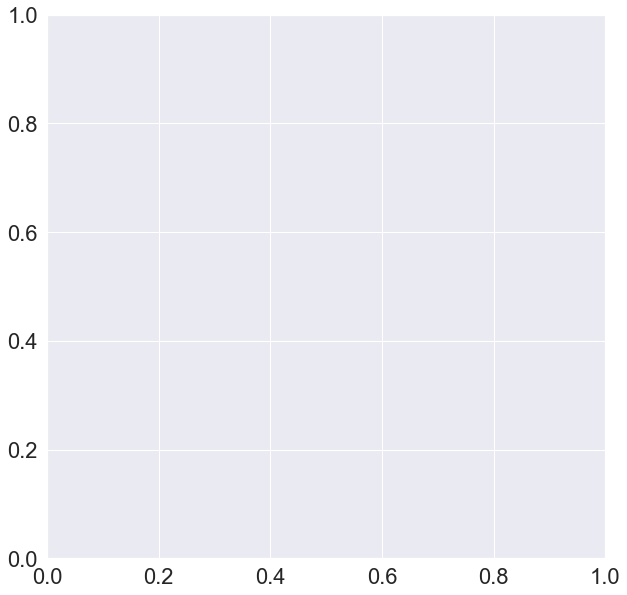

In [70]:
sns.set(style="whitegrid")
sns.set(font_scale=2)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot RMSE
sns.set_color_codes("pastel")

values = alpha_graph_df['params_desc'].tolist()

clrs = ['salmon' if (y == '\u03B1=1000') else 'steelblue' for y in values ]

s = sns.barplot(x="rmse", y="params_desc", data=alpha_graph_df,
                label="RMSE",
                palette=clrs)

# Add a legend and informative axis label

xlabel = "Max Iterations: " + str(best_max_iter) + " | Latent Factors: " + str(best_rank)
# xlabel


ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel=xlabel)
ax.set_title("Change in Error over Alpha")

sns.despine(left=True, bottom=True)
fig = s.get_figure()
# fig.savefig('support_data/alphas_20190905.png') 

---

---

---

---

---

---

One last thing, let's chart change in RMSE over change in alpha.

In [ ]:
alpha_graph_df = gs_vary_alpha.copy()

In [ ]:
alpha_graph_df['params_desc'] = (
                                '\u03B1=' + alpha_graph_df['alpha'].map(str) 
                                )
                                 

In [ ]:
alpha_graph_df

In [ ]:
sns.set(style="whitegrid")
sns.set(font_scale=2)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot RMSE
sns.set_color_codes("pastel")

values = alpha_graph_df['params_desc'].tolist()

clrs = ['salmon' if (y == '\u03B1=1000') else 'steelblue' for y in values ]

s = sns.barplot(x="rmse", y="params_desc", data=alpha_graph_df,
                label="RMSE",
                palette=clrs)

# Add a legend and informative axis label

xlabel = "Max Iterations: " + str(best_max_iter) + " | Latent Factors: " + str(best_rank)
# xlabel


ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel=xlabel)
ax.set_title("Change in Error over Alpha")

sns.despine(left=True, bottom=True)
fig = s.get_figure()
fig.savefig('support_data/alphas_20190905.png') 

Note those that iterations = 35 is the max of our grid.

In [ ]:
# hyper-param config
num_iterations = [20, 25, 40]
ranks = [4,5]
reg_params = [0.01, 0.1]
alphas = [40, 50, 100]

In [ ]:
# grid search and select best model
start_time = time.time()
final_model, params_errs = cr.train_ALS(gs_train, gs_val, eval_reg, 
                                        num_iterations, reg_params, 
                                        ranks, alphas)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

In [ ]:
param_errs_rd_2 = params_errs

In [ ]:
with open('support_data/params_errs_20190907b.pkl', 'wb') as f:
    pickle.dump(param_errs_rd_2, f)
    
# Example - load picklea
# pickle_in = open("support_data/params_errs_rd1.pkl","rb")
# pe1 = pickle.load(pickle_in)

#### Use this to reload the Grid Search results

In [ ]:
pickle_in = open('support_data/params_errs_20190907b.pkl', 'rb')
params_errs_2 = pickle.load(pickle_in)
                         

In [ ]:
gs_cols = ['max_iters', 'reg', 'rank', 'alpha', 'rmse']

In [ ]:
gs_df = pd.DataFrame(params_errs_2, columns=gs_cols)

In [ ]:
gs_df.head()

In [ ]:
min_err = gs_df.rmse.min()

In [ ]:
min_df = gs_df.loc[gs_df['rmse']==min_err]

In [ ]:
min_df

In [ ]:
best_max_iter = min_df['max_iters'].iloc[0]
best_reg = min_df['reg'].iloc[0]
best_rank = min_df['rank'].iloc[0]
best_alpha = min_df['alpha'].iloc[0]

Let's do some visual comparisons.

In [ ]:
gs_rank_match = (gs_df['rank']==best_rank)
gs_reg_match = (gs_df['reg']==best_reg)
gs_iter_match = (gs_df['max_iters']==best_max_iter)
gs_alpha_match = (gs_df['alpha']==best_alpha)

In [ ]:
gs_vary_rank = gs_df.loc[(gs_reg_match & gs_iter_match & gs_alpha_match),:]

In [ ]:
gs_vary_rank

In [ ]:
gs_vary_alpha = gs_df.loc[(gs_reg_match & gs_iter_match & gs_rank_match),:]

In [ ]:
gs_vary_alpha

In [ ]:
gs_vary_reg = gs_df.loc[(gs_alpha_match & gs_iter_match & gs_rank_match),:]

In [ ]:
gs_vary_reg

In [ ]:
gs_vary_iter = gs_df.loc[(gs_alpha_match & gs_reg_match & gs_rank_match),:]

In [ ]:
gs_vary_iter

So quick inspection on these, lets:
- keep `rank` = 5
- When compared to all the other combos, the differences in `alpha`s seem to not really move the needle > 500. so let's just call it `1000`
- Keep `maxIter` at `20`; experience to date with my assets seems to show 20 is max capability before technical difficulties arise.
- Similar with `alpha`, the marginal change in error due to changing `reg` is really small. So let's just assume the default `.01`.

So, that means we are done selecting! We may really be pushing overfitting.

One last thing, let chart change in RMSE over change in alpha.

In [ ]:
alpha_graph_df = gs_vary_alpha.copy()

In [ ]:
alpha_graph_df['params_desc'] = (
                                '\u03B1=' + alpha_graph_df['alpha'].map(str) 
                                )
                                 

In [ ]:
alpha_graph_df

In [ ]:
sns.set(style="whitegrid")
sns.set(font_scale=2)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot RMSE
sns.set_color_codes("pastel")

values = alpha_graph_df['params_desc'].tolist()

clrs = ['salmon' if (y == '\u03B1=1000') else 'steelblue' for y in values ]

s = sns.barplot(x="rmse", y="params_desc", data=alpha_graph_df,
                label="RMSE",
                palette=clrs)

# Add a legend and informative axis label

xlabel = "Max Iterations: " + str(best_max_iter) + " | Latent Factors: " + str(best_rank)
# xlabel


ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel=xlabel)
ax.set_title("Change in Error over Alpha")

sns.despine(left=True, bottom=True)
fig = s.get_figure()
#fig.savefig('support_data/alphas_20190905.png') 

In [ ]:
# hyper-param config
num_iterations = [20]
ranks = [3,4]
reg_params = [0.01]
alphas = [100, 500, 1000, 1500]

In [ ]:
# grid search and select best model
start_time = time.time()
final_model, params_errs = cr.train_ALS(gs_train, gs_val, eval_reg, 
                                        num_iterations, reg_params, 
                                        ranks, alphas)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

In [ ]:
# hyper-param config
num_iterations = [30, 50, 75, 100]
ranks = [5]
reg_params = [1, 5, 10]
alphas = [1000]

In [ ]:
# grid search and select best model
start_time = time.time()
final_model, params_errs = cr.train_ALS(gs_train, gs_val, eval_reg, 
                                        num_iterations, reg_params, 
                                        ranks, alphas)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

**OK**. Let's call it good. 

## Results 
Looks like the best parameters we could find are:
- `maxIter` = 20
- `rank` = 5
- `regParam` = 0.1 (default)
- `alpha` = 1000

Let's cross-validate this candidate model.

## Cross Validation

Let's cross-validate because we didn't actually do it in the grid search. We want to make sure that the selected model is not overfitting.

The built-in cross validator in `Spark` keeps breaking when I try to use it, so let's build our own function.

In [ ]:
k = 10

In [ ]:
folds = cr.get_spark_k_folds(train, k=k, random_seed=random_seed)

In [ ]:
# Create ALS instance for cv with our chosen parametrs
als_cv = ALS(maxIter=best_max_iter,
          rank=best_rank,
          userCol='account_id',
          itemCol='comic_id',
          ratingCol='bought',
          implicitPrefs=True,
          regParam=best_reg,
          alpha=best_alpha,
          coldStartStrategy='drop', # we want to drop so can get through CV
          seed=random_seed)

In [ ]:
errors = cr.get_cv_errors(folds, als_cv, eval_reg)

In [ ]:
# Make sure that # of errors = k
k == len(errors)

In [ ]:
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(errors), np.std(errors) * 2))

Looks stable. Let's go with it.

## Test the Candidate Model

Test vs our holdout set.

In [ ]:
best_max_iter = 20
best_reg = 0.1
best_rank = 5
best_alpha = 1000

In [ ]:
# Create ALS instance and fit model
als = ALS(maxIter=best_max_iter,
          rank=best_rank,
          userCol='account_id',
          itemCol='comic_id',
          ratingCol='bought',
          implicitPrefs=True,
          regParam=best_reg,
          alpha=best_alpha,
          coldStartStrategy='drop', # To get our eval
          seed=random_seed)
model_use = als.fit(train)

In [ ]:
# get predictions on test
test_preds = model_use.transform(test)

# Evaluate test
test_rmse = eval_reg.evaluate(test_preds)
test_rmse

Well, this is unexpected. Test error being noticeably lower than train error usually indicates an unknown fit. Since we trained on 'train' data we would expect test error to be at minimum as worse AND _probably_ a little worse than train. Not less than.

It's not THAT much better, but need to make note of it. For now we need to move on.

In [ ]:
# Create ALS instance and fit model
als = ALS(maxIter=best_max_iter,
          rank=best_rank,
          userCol='account_id',
          itemCol='comic_id',
          ratingCol='bought',
          implicitPrefs=True,
          regParam=best_reg,
          alpha=best_alpha,
          coldStartStrategy='nan', # To get our eval
          seed=random_seed)
model_use = als.fit(train)

#### Save the item factors for future use!

In [ ]:
item_factors = model_use.itemFactors.toPandas()

In [ ]:
item_factors.shape

In [ ]:
!ls

In [ ]:
item_factors.to_pickle("support_data/item_factors.pkl")

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
item_factors.head()

Test unpickle

In [ ]:
unpickled_items = pd.read_pickle('support_data/item_factors.pkl')

### Get Top N recommendations for Single User

Let's make a reference list of `account_id`'s, for testing purposes.

In [ ]:
n_to_test = 2

users = (sold.select(als.getUserCol())
                          .sample(False
                                  ,n_to_test/sold.count()
                                  )
        )
users.persist()
users.show(2)

We developed and wrote the functionality out to a function in `comic_recs.py`

###  Testing function!

- Pass the function to a pandas dataframe. 
- Function will ask for an account_id.
- Will return top n, n defined in parameters.

In [ ]:
top_n_df = cr.get_top_n_new_recs(spark=spark, model=model_use, topn=5)
top_n_df

In [ ]:
top_n_df = cr.get_top_n_new_recs(spark=spark, model=model_use, topn=5)
top_n_df

In [ ]:
top_n_df = cr.get_top_n_new_recs(spark=spark, model=model_use, topn=10)
top_n_df

## Conclusions
- Seems realistic? Only three tests, but the results seem 'individualized' in the sense that there is no overlap between the sets (albeit small samples).

## Save the Model!

In [ ]:
model_use.save('models/als_use')

## Retrieving Saved Model

In [ ]:
comic_rec_model = ALSModel.load('models/als_use')

In [ ]:
top_n_df = cr.get_top_n_new_recs(spark=spark, model=comic_rec_model, topn=10)
top_n_df